In [1]:
import os
import torch
import kagglehub

from torch.utils.data import DataLoader

import torchvision.transforms as transforms

from gtsdb_dataset import GTSDBDataset

In [2]:
download_path = kagglehub.dataset_download("safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb")
# actual_root_dir = os.path.join(download_path, "subdirectory_name")  # Adjust this path\

download_path

'C:\\Users\\timon\\.cache\\kagglehub\\datasets\\safabouguezzi\\german-traffic-sign-detection-benchmark-gtsdb\\versions\\1'

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torchvision.transforms as transforms

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalize a tensor image with mean and standard deviation.
    
    Args:
        tensor (torch.Tensor): Normalized image tensor [C, H, W]
        mean (list): Mean used for normalization
        std (list): Standard deviation used for normalization
        
    Returns:
        torch.Tensor: Denormalized image tensor
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = tensor.clone()
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def plot_image_with_bbox_fixed(image, target, idx, class_names=None, original_size=(1360, 800)):
    """
    Plot an image with its bounding box, handling the coordinate scaling correctly.
    
    Args:
        image (torch.Tensor): Image tensor [C, H, W]
        target (dict): Target dictionary with 'boxes' and 'labels'
        idx (int): Index of the image in the batch
        class_names (dict, optional): Dictionary mapping class IDs to names
        original_size (tuple): Original image size (width, height)
    """
    # Get current image size
    _, current_height, current_width = image.shape
    
    # Denormalize the image and convert to numpy array
    img = denormalize(image)
    img_np = img.permute(1, 2, 0).numpy()
    
    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_np)
    
    # Set the title
    if class_names is None:
        title = f"Image {idx}"
    else:
        # Get class name if available
        label = target['labels'][0].item()
        class_name = class_names.get(label, f"Class {label}")
        title = f"Image {idx}: {class_name}"
    
    ax.set_title(title)
    
    # Extract boxes and labels
    boxes = target['boxes'][0].tolist()  # Get the first box (index 0)
    
    # Get original box coordinates
    x1, y1, x2, y2 = boxes
    
    # Scale the coordinates to match the resized image
    x1_scaled = (x1 / original_size[0]) * current_width
    y1_scaled = (y1 / original_size[1]) * current_height
    x2_scaled = (x2 / original_size[0]) * current_width
    y2_scaled = (y2 / original_size[1]) * current_height
    
    # Calculate width and height
    width = x2_scaled - x1_scaled
    height = y2_scaled - y1_scaled
    
    # Create rectangle patch
    rect = patches.Rectangle(
        (x1_scaled, y1_scaled), width, height, linewidth=2, 
        edgecolor='r', facecolor='none'
    )
    
    # Add the rectangle to the plot
    ax.add_patch(rect)
    
    # Add label if class_names is provided
    if class_names is not None:
        label = target['labels'][0].item()
        class_name = class_names.get(label, f"Class {label}")
        ax.text(
            x1_scaled, y1_scaled - 5, 
            f"{class_name}",
            bbox=dict(facecolor='white', alpha=0.7),
            fontsize=10
        )
    
    plt.axis('on')  # Show axes to help with debugging
    plt.tight_layout()
    return fig

# Function to visualize a batch of images with their bounding boxes
def visualize_batch(images, targets, class_names=None, max_images=4):
    """
    Visualize a batch of images with their bounding boxes.
    
    Args:
        images (list): List of image tensors
        targets (list): List of target dictionaries
        class_names (dict, optional): Dictionary mapping class IDs to names
        max_images (int): Maximum number of images to display
    """
    n_images = min(len(images), max_images)
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    
    if n_images == 1:
        axes = [axes]
    
    for i in range(n_images):
        img = denormalize(images[i])
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[i].imshow(img_np)
        
        # Get box coordinates
        box = targets[i]['boxes'][0].tolist()
        x1, y1, x2, y2 = box
        
        # Scale to current size
        _, h, w = images[i].shape
        x1_scaled = (x1 / 1360) * w  # 1360 is typical GTSDB image width
        y1_scaled = (y1 / 800) * h   # 800 is typical GTSDB image height
        x2_scaled = (x2 / 1360) * w
        y2_scaled = (y2 / 800) * h
        
        # Draw bounding box
        width = x2_scaled - x1_scaled
        height = y2_scaled - y1_scaled
        rect = patches.Rectangle(
            (x1_scaled, y1_scaled), width, height, 
            linewidth=2, edgecolor='r', facecolor='none'
        )
        axes[i].add_patch(rect)
        
        # Add label
        if class_names is not None:
            label = targets[i]['labels'][0].item()
            class_name = class_names.get(label, f"Class {label}")
            axes[i].set_title(f"{class_name}")
        
        axes[i].axis('on')
    
    plt.tight_layout()
    return fig

Dataset loaded successfully with 852 samples
Loaded batch with 4 images
First image shape: torch.Size([3, 224, 224])
First target: {'boxes': tensor([[842., 516., 870., 539.]]), 'labels': tensor([13]), 'category_id': tensor([3])}


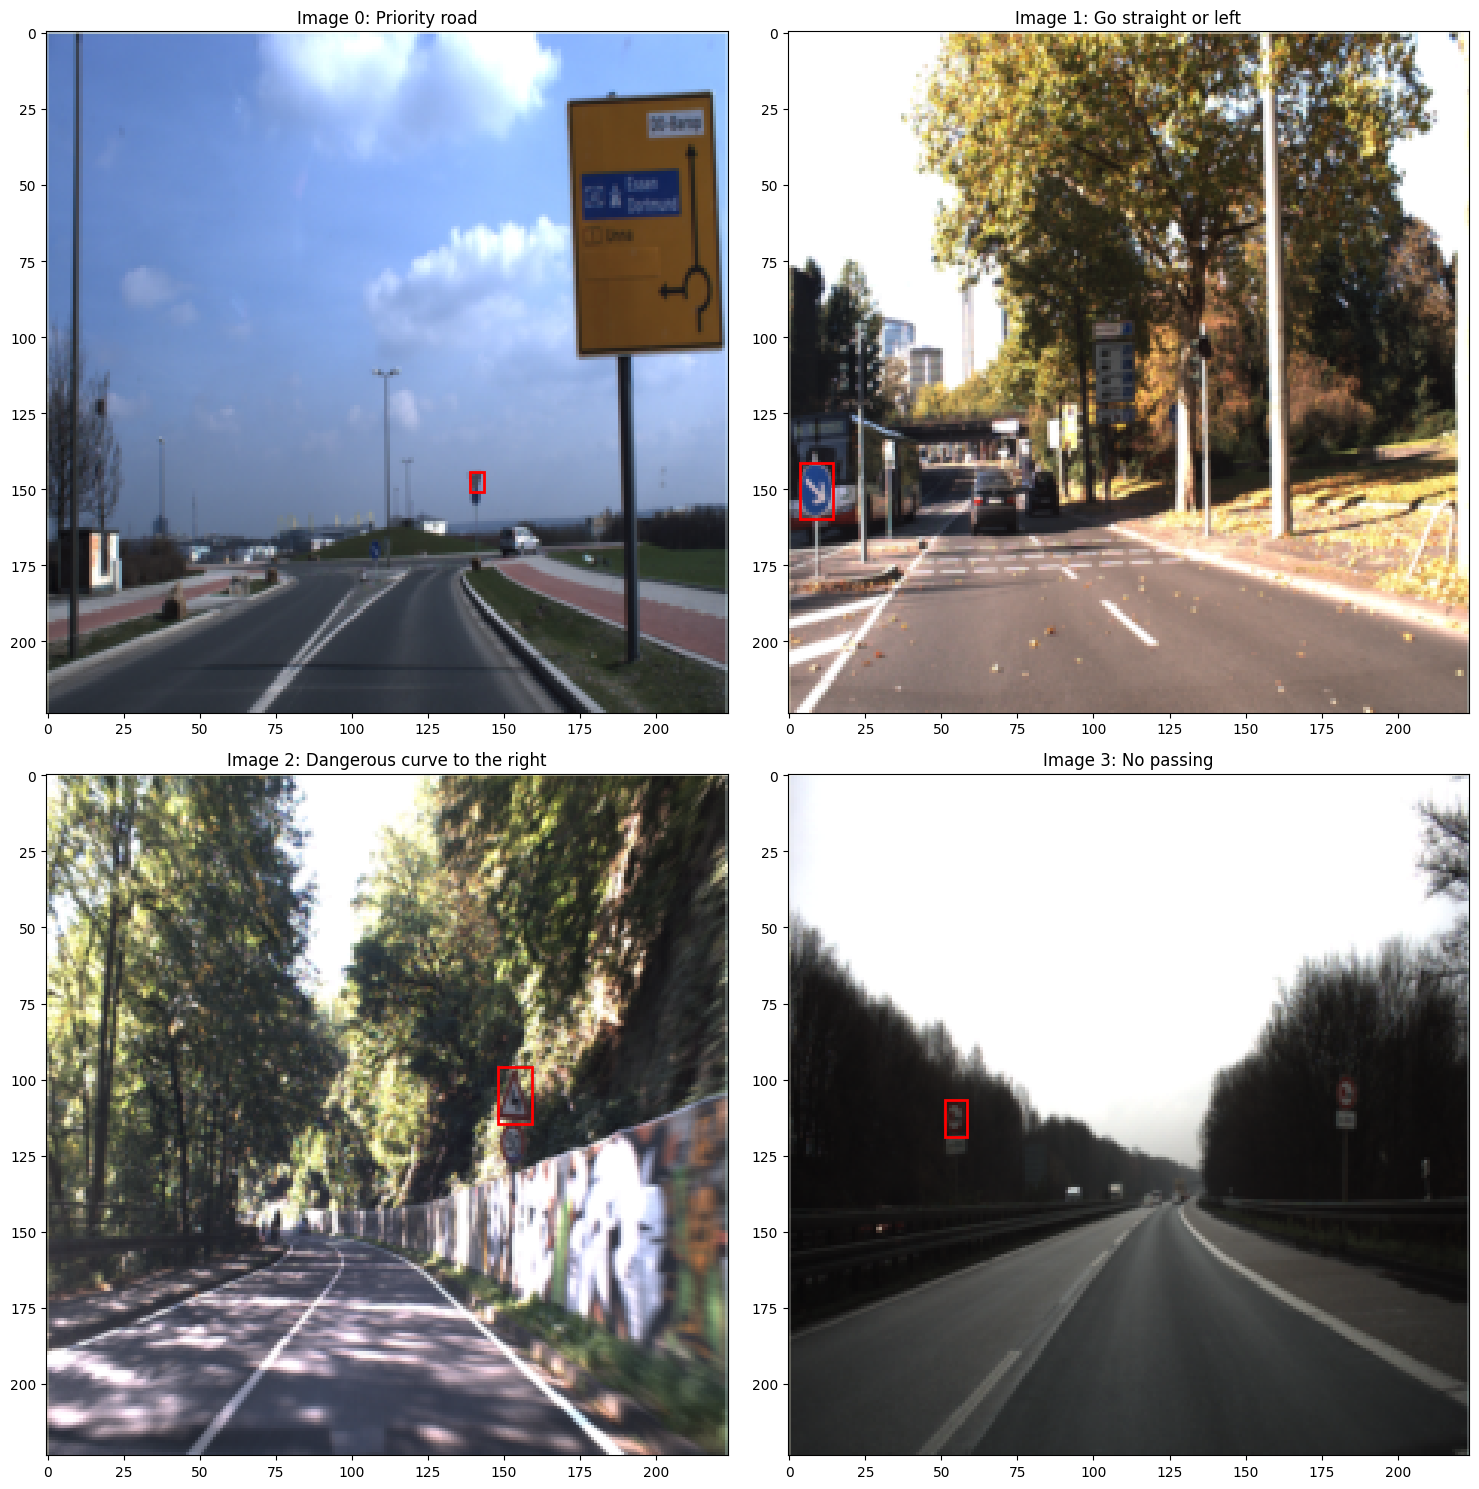

In [4]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Import the dataset class from your file
# Note: This assumes gtsdb_dataset.py is in the same directory
from gtsdb_dataset import GTSDBDataset

# Define a proper named function for the collate_fn
def collate_fn(batch):
    """
    Custom collate function for object detection datasets.
    """
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Denormalize a tensor image with mean and standard deviation.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = tensor.clone()
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    return img

# Dictionary mapping class IDs to names
class_names = {
    0: 'Speed limit 20',
    1: 'Speed limit 30',
    2: 'Speed limit 50',
    3: 'Speed limit 60',
    4: 'Speed limit 70',
    5: 'Speed limit 80',
    7: 'End of speed limit 80',
    8: 'Speed limit 100',
    9: 'Speed limit 120',
    10: 'No passing',
    11: 'No passing for vehicles over 3.5t',
    12: 'Right-of-way at the next intersection',
    13: 'Priority road',
    14: 'Yield',
    15: 'Stop',
    16: 'No vehicles',
    17: 'No vehicles over 3.5t',
    18: 'No entry',
    19: 'General caution',
    20: 'Dangerous curve to the left',
    21: 'Dangerous curve to the right',
    22: 'Double curve',
    23: 'Bumpy road',
    24: 'Slippery road',
    25: 'Road narrows on the right',
    26: 'Road work',
    27: 'Traffic signals',
    28: 'Pedestrians',
    29: 'Children crossing',
    30: 'Bicycles crossing',
    31: 'Beware of ice/snow',
    32: 'Wild animals crossing',
    33: 'End of all speed and passing limits',
    34: 'Turn right ahead',
    35: 'Turn left ahead',
    36: 'Ahead only',
    37: 'Go straight or right',
    38: 'Go straight or left',
    39: 'Keep right',
    40: 'Keep left',
    41: 'Roundabout mandatory',
    42: 'End of no passing',
    43: 'End of no passing for vehicles over 3.5t'
}

def main():
    # Define data path - change this to your dataset location
    data_path = download_path
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create the dataset
    try:
        train_dataset = GTSDBDataset(
            root_dir=data_path,
            split='train',
            transform=transform
        )
        
        print(f"Dataset loaded successfully with {len(train_dataset)} samples")
        
        # Create a DataLoader
        train_loader = DataLoader(
            train_dataset,
            batch_size=4,
            shuffle=True,
            num_workers=0,
            collate_fn=collate_fn
        )
        
        # Get a batch of images and targets
        for images, targets in train_loader:
            print(f"Loaded batch with {len(images)} images")
            print(f"First image shape: {images[0].shape}")
            print(f"First target: {targets[0]}")
            
            # Create a figure to display the batch
            plt.figure(figsize=(15, 15))
            
            # Process up to 4 images
            for i in range(min(4, len(images))):
                # Create subplot
                plt.subplot(2, 2, i+1)
                
                # Denormalize image
                img = denormalize(images[i])
                img_np = img.permute(1, 2, 0).numpy()
                
                # Display image
                plt.imshow(img_np)
                
                # Get original box coordinates
                box = targets[i]['boxes'][0].tolist()
                x1, y1, x2, y2 = box
                
                # Original image dimensions for GTSDB are typically 1360x800
                original_width, original_height = 1360, 800
                
                # Get current dimensions
                _, current_height, current_width = images[i].shape
                
                # Scale box coordinates to match the resized image
                x1_scaled = (x1 / original_width) * current_width
                y1_scaled = (y1 / original_height) * current_height
                x2_scaled = (x2 / original_width) * current_width
                y2_scaled = (y2 / original_height) * current_height
                
                # Create rectangle
                width = x2_scaled - x1_scaled
                height = y2_scaled - y1_scaled
                
                rect = plt.Rectangle(
                    (x1_scaled, y1_scaled), width, height,
                    linewidth=2, edgecolor='r', facecolor='none'
                )
                
                # Add the rectangle to the plot
                plt.gca().add_patch(rect)
                
                # Add class label
                label = targets[i]['labels'][0].item()
                class_name = class_names.get(label, f"Class {label}")
                plt.title(f"Image {i}: {class_name}")
                
                # Show axes for debugging
                plt.axis('on')
            
            plt.tight_layout()
            plt.show()
            
            # Just process one batch for this example
            break
            
    except Exception as e:
        print(f"Error loading dataset: {e}")

if __name__ == "__main__":
    main()